### EDA (exploratory data analysis) - Anomaly Detection - Victorian household energy consumption

Having a play with common time series libraries, some of them are inspired by: https://neptune.ai/blog/anomaly-detection-in-time-series

This notebook covers the following experiments:

- Dataset and basic time sereis plots
- IsolationForest based detection
- Prophet fit
- Forecasting based detection with ARIMA (autoregressive integrated moving average) and IQR (interquartile range detection)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from time import time
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
# import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

### Dataset

This data (https://data.gov.au/dataset/ds-dga-0f3d60db-bd63-419e-9cd9-0a663f3abbc9/details) is made up of two elements:
- Responses to a survey from 25 Victorian householders about their energy consumption
- Energy consumption data (in Watt Hours (WH)) for each household in the sample from 1 April 2012 to 31 March 2014...

In [3]:
df = pd.read_csv('data/electricityconsumptionbenchmarkssurveydataaergovhack.csv')

In [4]:
df.head(5)

,respondent,OUTPUT_DATE,TYPE,E_0000_WH,E_0030_WH,E_0100_WH,E_0130_WH,E_0200_WH,E_0230_WH,E_0300_WH,E_0330_WH,E_0400_WH,E_0430_WH,E_0500_WH,E_0530_WH,E_0600_WH,E_0630_WH,E_0700_WH,E_0730_WH,E_0800_WH,E_0830_WH,E_0900_WH,E_0930_WH,E_1000_WH,E_1030_WH,E_1100_WH,E_1130_WH,E_1200_WH,E_1230_WH,E_1300_WH,E_1330_WH,E_1400_WH,E_1430_WH,E_1500_WH,E_1530_WH,E_1600_WH,E_1630_WH,E_1700_WH,E_1730_WH,E_1800_WH,E_1830_WH,E_1900_WH,E_1930_WH,E_2000_WH,E_2030_WH,E_2100_WH,E_2130_WH,E_2200_WH,E_2230_WH,E_2300_WH,E_2330_WH
0,8927,1/04/2012,general,426,396,340,392,348,378,362,356,382,352,248,176,232,176,206,204,176,234,174,228,198,190,210,168,230,166,230,450,814,804,1078,698,884,732,806,738,1076,750,828,760,918,756,898,1228,710,1048,674,1528
1,8927,2/04/2012,general,1872,1920,1620,304,230,268,198,248,198,212,232,196,246,198,204,240,198,242,188,144,178,134,188,136,222,328,420,396,438,418,436,432,422,450,402,444,390,550,402,410,350,398,380,1018,1994,1584,1390,1018
2,8927,3/04/2012,general,766,528,320,474,384,338,326,356,300,356,300,358,304,358,304,360,304,356,326,228,174,224,188,334,368,1572,802,886,470,412,372,464,400,472,408,454,428,424,926,1180,1122,1266,524,814,756,1610,1436,512
3,8927,4/04/2012,general,696,546,408,390,362,384,186,198,142,192,142,176,158,144,186,138,194,138,178,156,160,170,148,188,154,184,246,502,364,404,464,400,468,390,464,410,446,424,566,456,418,406,354,592,1354,970,874,850
4,8927,5/04/2012,general,632,490,506,330,364,308,352,318,322,348,308,362,310,348,328,310,362,306,344,196,174,230,174,232,246,396,994,1102,1088,942,368,358,410,368,482,446,482,440,192,218,172,528,950,982,1134,764,512,758


In [5]:
df['respondent'].nunique()

25

In [6]:
df['respondent'].value_counts()

17625    2190
3117     1460
18272    1382
6463     1382
1858     1356
         ... 
6460      673
4119      672
16163     662
16619     643
1569      547
Name: respondent, Length: 25, dtype: int64

In [7]:
df['TYPE'].unique()

array(['general', 'controlled load', 'generation'], dtype=object)

In [8]:
# Pick up a household
respondent = 17625

df[df['respondent']==respondent].head(3)

,respondent,OUTPUT_DATE,TYPE,E_0000_WH,E_0030_WH,E_0100_WH,E_0130_WH,E_0200_WH,E_0230_WH,E_0300_WH,E_0330_WH,E_0400_WH,E_0430_WH,E_0500_WH,E_0530_WH,E_0600_WH,E_0630_WH,E_0700_WH,E_0730_WH,E_0800_WH,E_0830_WH,E_0900_WH,E_0930_WH,E_1000_WH,E_1030_WH,E_1100_WH,E_1130_WH,E_1200_WH,E_1230_WH,E_1300_WH,E_1330_WH,E_1400_WH,E_1430_WH,E_1500_WH,E_1530_WH,E_1600_WH,E_1630_WH,E_1700_WH,E_1730_WH,E_1800_WH,E_1830_WH,E_1900_WH,E_1930_WH,E_2000_WH,E_2030_WH,E_2100_WH,E_2130_WH,E_2200_WH,E_2230_WH,E_2300_WH,E_2330_WH
3462,17625,1/04/2012,general,68,50,92,20,86,60,44,82,28,72,72,24,82,50,42,68,58,36,228,286,0,0,166,186,0,0,0,0,0,0,0,0,0,2,6,14,60,48,212,232,202,304,458,404,248,284,410,594
3463,17625,1/04/2012,generation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,18,0,90,244,566,452,322,380,698,554,400,494,428,254,286,232,238,114,76,32,10,0,0,0,0,0,0,0,0,0,0,0
3464,17625,1/04/2012,controlled load,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1862,406,0,0,810,1146,0,0,0,0,0,0,1022,556,0,0,0,0,0,62,1756,0,0,1816,2312,2312,2328,314,0,152


In [9]:
type_of_interest = 'general'

# Get a time series dataset
df_ts = df[(df['respondent']==respondent) & (df['TYPE']==type_of_interest)].copy()

In [10]:
# Get last 90 days
df_ts = df_ts.tail(90)

In [11]:
cols_hourly = [col for col in df_ts.columns if 'E_' in col]

In [12]:
# Sum up to get the daily WHs
df_ts['E_WH'] = df_ts[list(cols_hourly)].sum(axis=1)

In [13]:
df_ts['date'] = df_ts['OUTPUT_DATE'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [14]:
df_ts = df_ts.set_index('date')

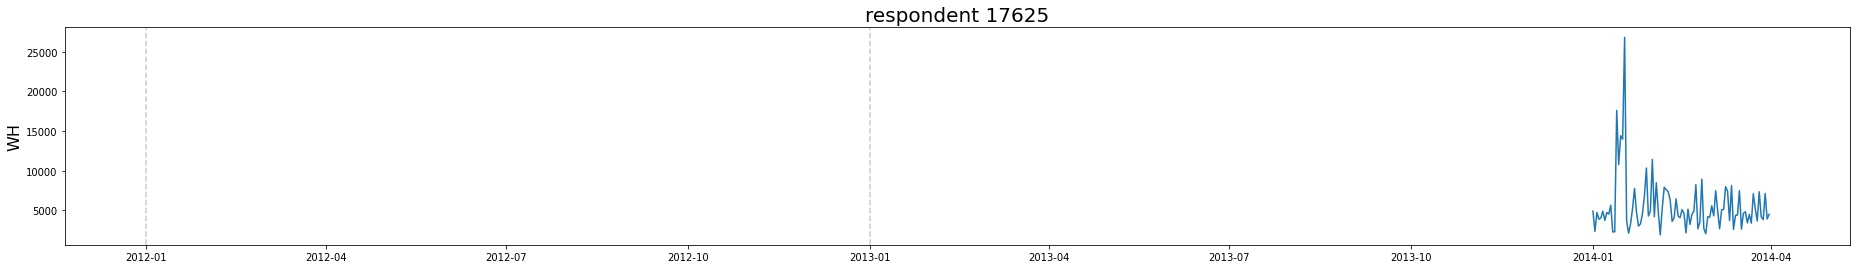

In [15]:
plt.figure(figsize=(32,4))
plt.plot(df_ts[['E_WH']])
plt.title(f'respondent {respondent}', fontsize=20)
plt.ylabel('WH', fontsize=16)
for year in range(2012,2014):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [16]:
df_ts[['E_WH']].isnull().values.any()

False

### Plot decompose with statsmodels.tsa.seasonal

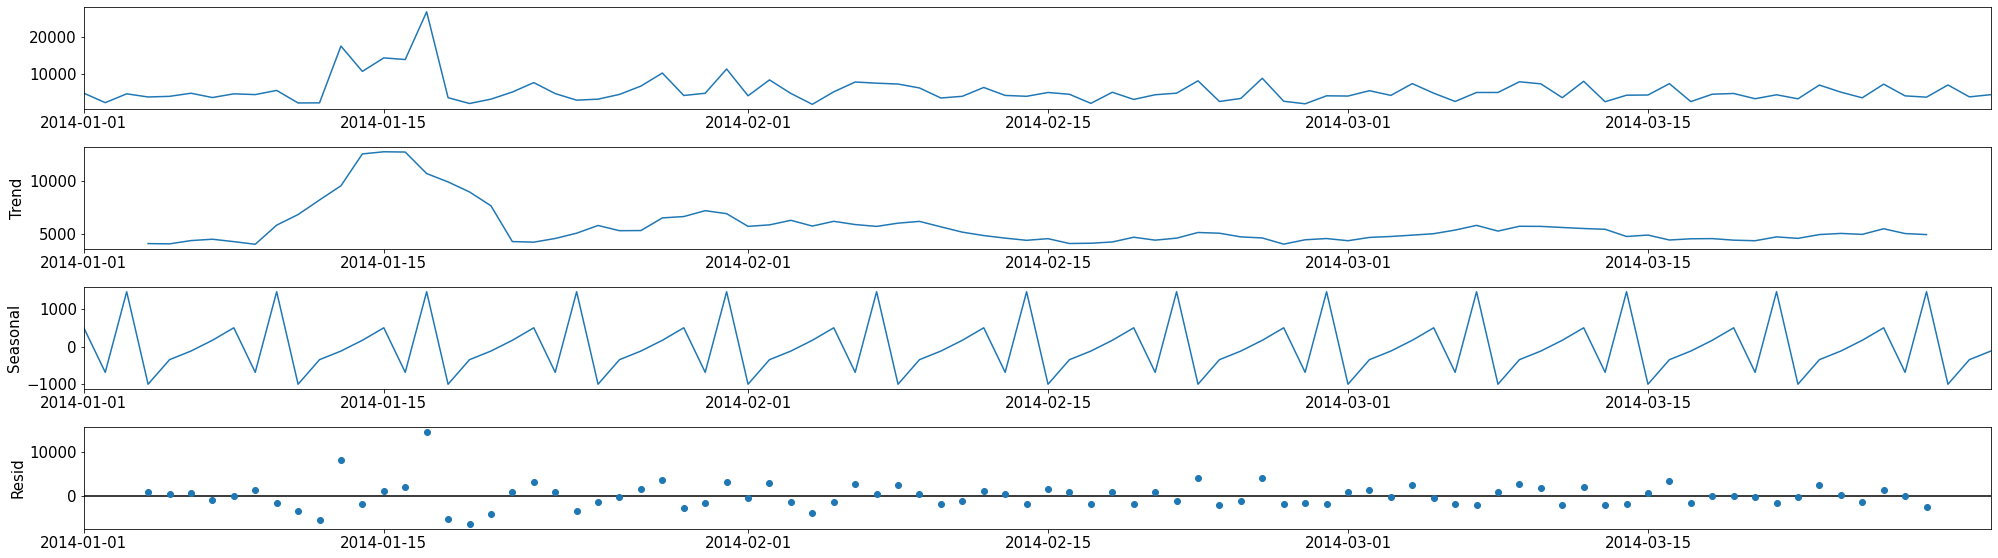

In [17]:
plt.rc('figure', figsize=(28,8))
plt.rc('font', size=15)


result = seasonal_decompose(df_ts[['E_WH']], model='additive')
fig = result.plot()

### IsolationForest (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

In [18]:
from sklearn.ensemble import IsolationForest

In [19]:
# plt.rc('figure',figsize=(32,6))
# plt.rc('font',size=15)
# df_ts[['E_WH']].plot()

In [20]:
outliers_fraction = float(.02)

In [21]:
df_ts_working = df_ts[['E_WH']].copy()

In [22]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_ts_working.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [23]:
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.02)

In [24]:
df_ts_working.head()

,E_WH
date,
2014-01-01,4902
2014-01-02,2350
2014-01-03,4731
2014-01-04,3877
2014-01-05,4050


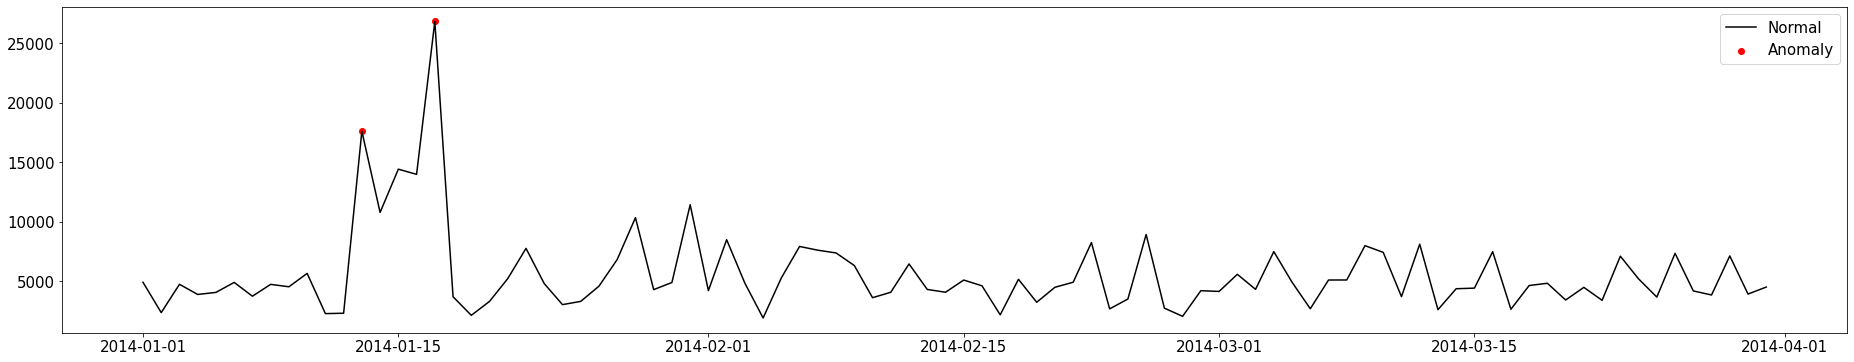

In [25]:
df_ts_working['anomaly'] = model.predict(data)

fig, ax = plt.subplots(figsize=(32,6))

a = df_ts_working.loc[df_ts_working['anomaly'] == -1, ['E_WH']] #anomaly

ax.plot(df_ts_working.index, df_ts_working['E_WH'], color='black', label = 'Normal')
ax.scatter(a.index,a['E_WH'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

### Prophet

In [26]:
# !pip install holidays==0.24
# !pip install pandas==1.5.3

In [27]:
from fbprophet import Prophet

In [28]:
ts = pd.DataFrame()
ts['ds'] = df_ts_working.index
ts['y'] = df_ts_working['E_WH'].values

In [29]:
print(pd.__version__)

1.5.3


In [30]:
m = Prophet()
m.fit(ts)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
future = m.make_future_dataframe(periods=7 * 1, freq='D')

In [32]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
92,2014-04-03,3582.361779,-958.985237,7948.138899,4407.365380,4407.364156,4407.366611
93,2014-04-04,5741.124353,1577.333443,10238.367366,4383.005199,4383.002672,4383.007449
94,2014-04-05,3585.098748,-518.369578,7835.576989,4358.645018,4358.641015,4358.648648
95,2014-04-06,3967.963564,-545.779058,8385.907061,4334.284837,4334.279281,4334.289768
96,2014-04-07,4245.214751,-291.827400,8406.953993,4309.924656,4309.917572,4309.931059


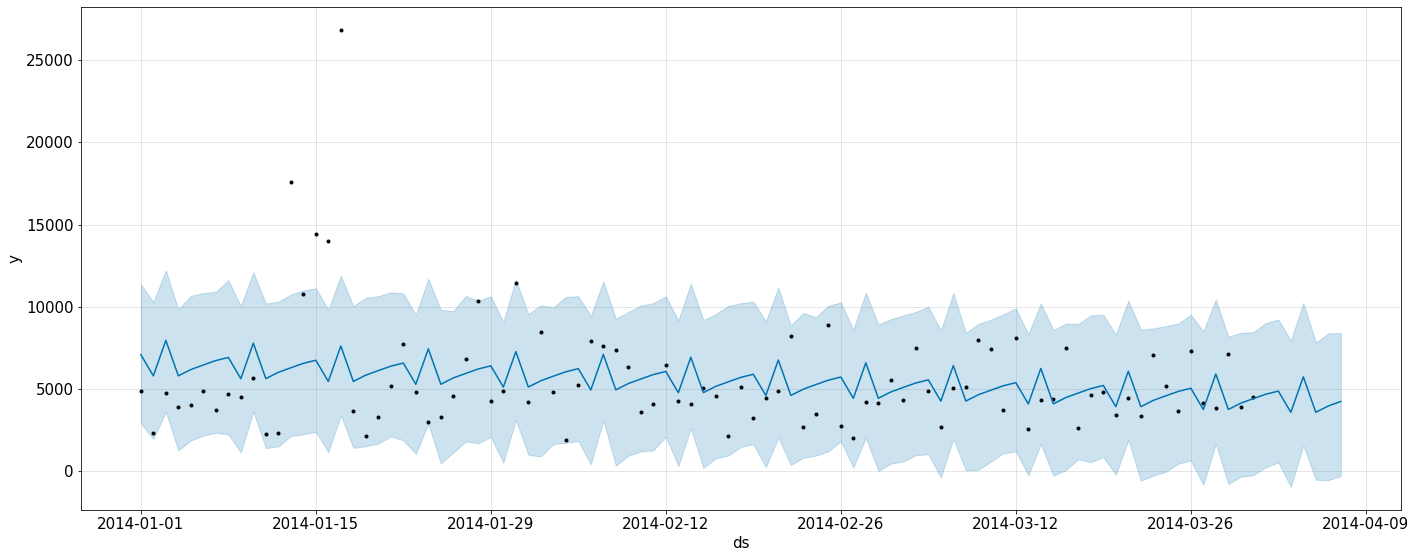

In [33]:
fig_forecast_1 = m.plot(forecast, figsize=(20, 8))

In [34]:
# Fitting is quite 'plat', to do: 

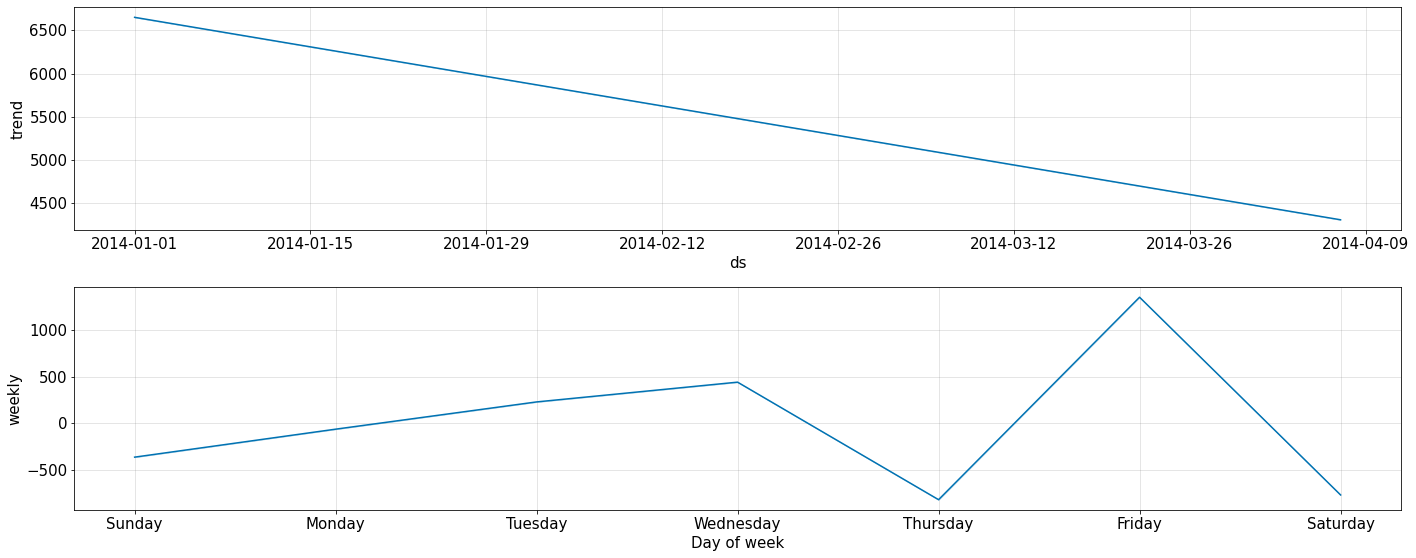

In [35]:
fig_forecast_2 = m.plot_components(forecast, figsize=(20, 8))

### Forecasting based detection with ARIMA (autoregressive integrated moving average) and IQR (interquartile range detection)

In [36]:

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print('Series is not stationary')
    else:
        print('Series is stationary')


check_stationarity(df_ts_working['E_WH'])

model = ARIMA(df_ts_working['E_WH'], order=(30,0,5))
model_fit = model.fit()

# Forecast
df_ts_working['forecast'] = model_fit.predict(start=df_ts_working.index[0], end=df_ts_working.index[-1])

# Calculate IQR and define a threshold for anomalies
Q1 = df_ts_working['forecast'].quantile(0.25)
Q3 = df_ts_working['forecast'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5 * IQR

# Find anomalies
df_ts_working['anomaly_ARIMA_IQR'] = np.where((df_ts_working['E_WH'] - df_ts_working['forecast']).abs() > threshold, df_ts_working['E_WH'], np.nan)

ADF Statistic: -6.997250127004634
p-value: 7.478432970854301e-10
Series is stationary


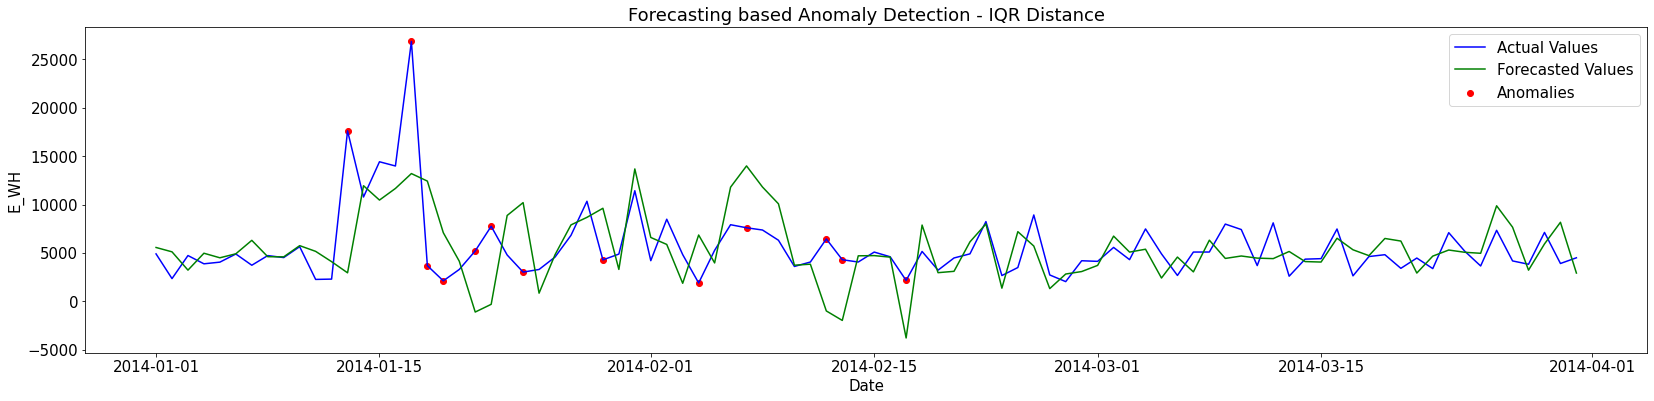

In [37]:
plt.figure(figsize=(28, 6))
plt.plot(df_ts_working.index, df_ts_working['E_WH'], label='Actual Values', color='blue')  # Plot of actual values
plt.plot(df_ts_working.index, df_ts_working['forecast'], label='Forecasted Values', color='green')  # Plot of forecasted values
plt.scatter(df_ts_working.index, df_ts_working['anomaly_ARIMA_IQR'], color='red', label='Anomalies')  # Scatter plot for anomalies
plt.legend()
plt.xlabel('Date')
plt.ylabel('E_WH')
plt.title('Forecasting based Anomaly Detection - IQR Distance')
plt.show()

In [38]:
# Misc.

In [39]:
# Prophet with additional regressors?
# Ensebmle with feedback input

In [40]:
# other libraries worth testing: 

# darts https://unit8co.github.io/darts/
# https://github.com/georgian-io/pyoats?tab=readme-ov-file

In [41]:
# Some research papers

# https://hpi.de/fileadmin/user_upload/fachgebiete/naumann/publications/PDFs/2022_schmidl_anomaly.pdf
# https://dl.acm.org/doi/10.14778/3538598.3538602
# https://dl.acm.org/doi/10.1145/3444690